In [5]:
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from stingray.pulse import epoch_folding_search
from stingray.pulse import get_orbital_correction_from_ephemeris_file
import Important_Functions as IF
import scipy.stats as st
from importlib import reload

In [18]:
#To reload functions - Keep in mind !
reload(IF)

<module 'Important_Functions' from '/Users/samsonmercier/Desktop/UNIGE/ap-lab-i-2022/notebooks/Important_Functions.py'>

## Importing data

In [30]:
#Retrieving data for source file
Time_phase_file = pf.open('sourceA.evt')

#Getting event arrival time data
Time_phase_data=Time_phase_file[1].data

## Getting GTIs

In [8]:
#Retrieving the GTIs
GTI_phase_file = Time_phase_file[2]

#Re-formatting the GTIs so that we can use them in the Stingray package
new_gtis=[]
for i in GTI_phase_file.data:
    new_gtis.append((i['START'], i['STOP']))


## Getting the event arrival times taking into account the orbital correction

In [9]:
#Setting up the parameters used by the Stingray documentation to correct the event arrival times

#Reference time in MJD
base_time = Time_phase_file[1].header['MJDREFI']+Time_phase_file[1].header['MJDREFF']

#Start time of observations in seconds
start_time = Time_phase_file[1].header['TSTART']/(24*3600)

#End time of observations in seconds
end_time = Time_phase_file[1].header['TSTOP']/(24*3600)

#Getting the correct_time function from the parameters defined above 
#and the orbit_t2.txt file containing the orbital parameters of Cen-X3
correct_time = get_orbital_correction_from_ephemeris_file(base_time+start_time, base_time+end_time, parfile='orbit_t2.txt')[0]

#Applying the correct_time function to our event arrival times
correct_orbit_time = correct_time(Time_phase_file[1].data['TIME'], base_time)



/opt/anaconda3/envs/testenv/lib/python3.10/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Assuming events are already referred to the solar system barycenter (timescale is TDB)
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
2022-10-14 10:10:16.653 | DEBUG    | pint.toa:__init__:1310 - No pulse number flags found in the TOAs
2022-10-14 10:10:16.654 | DEBUG    | pint.toa:compute_TDBs:2139 - Computing TDB columns.
2022-10-14 10:10:16.655 | DEBUG    | pint.toa:compute_TDBs:2164 - Using EPHEM = DE405 for TDB calculation.
2022-10-14 10:10:16.728 | DEBUG    | pint.toa:compute_posvels:2255 - Computing PosVels of observatories and Earth, using DE405
2022-10-14 10:10:16.736 | DEBUG    | pint.toa:compute_posvels:2310 - SSB obs pos [0. 0. 0.] m
2022-10-14 10:10:18.397 | INFO     | pint.solar_system_ephemerides:_load_kernel_link:54 - Set solar system ephemeris to de405 from download
2022-10-14 10:10:18.422 | DEBUG    | pint.toa:compute_posvels:2324 - Adding columns ssb_

## Using the event arrival times with orbital correction and the Stingray function epoch_folding_search to find pulse frequency

In [10]:
#Defining frequencies to try - required for epoch_folding_search
#Can either take a large range but then the resolution is low
#Or small range with high resolution -> could maybe do this iteratively
trial_freqs = np.linspace(0.208, 0.209, 1000)

#Getting the power as a function of frequency from 1. the event arrival times and 
#2. the event arrival times with orbital correction to show the difference

L = epoch_folding_search(Time_phase_data['TIME'], trial_freqs, gti=new_gtis)

correct_L = epoch_folding_search(correct_orbit_time, trial_freqs, segment_size=20000, gti=new_gtis)

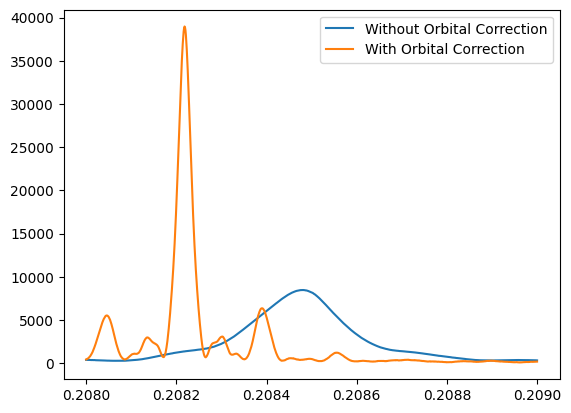

In [11]:
#Plotting the power as a function energy
plt.plot(L[0], L[1], label='Without Orbital Correction')
plt.plot(correct_L[0], correct_L[1], label='With Orbital Correction')
plt.legend()

# Getting the pulse profile matrix with orbitally corrected time segments

## Segmenting data

In [122]:
# We separate the data into 20 segments 

#We change the number of events we use 
#so that it can be divided by 20
size=1387000

#Getting corresponding sizes of bins
seg_size = int(size/20)

#Making lists that will contain the 20 segments of time and PI data
#We extract the PI data to get the periodogram for each segment.
Time_segments = []
PI_segments = []

#Populating the time and PI segment lists
for i in range(20):
    Time_segments.append(correct_orbit_time[seg_size*i:seg_size*(i+1)])
    PI_segments.append(Time_phase_data['PI'][seg_size*i:seg_size*(i+1)])


## Get the periodogram for the segments

In [123]:
freq_seg, power_seg = IF.get_power_and_freq(Time_segments, PI_segments, 20)

## Getting the first harmonic frequencies and regression coefficients

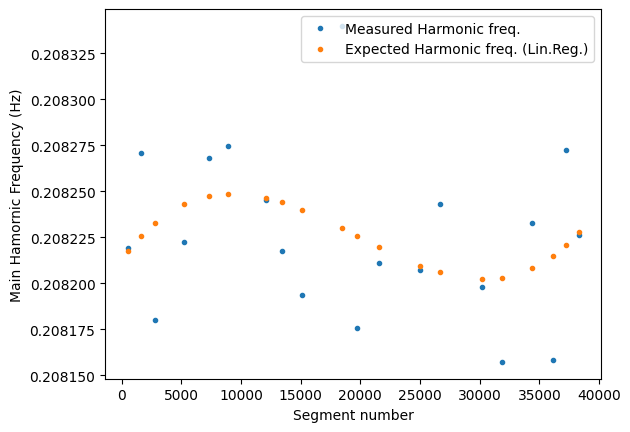

In [124]:
reg, bins = IF.Harmonic_funk(3, 0.01, Time_phase_data['TIME'][0], Time_segments, freq_seg, power_seg)

## Getting the pulse profile matrix

15
14
9
12
11
10
9
10
11
9
13
9
6
10
16
7
11
7
9
8


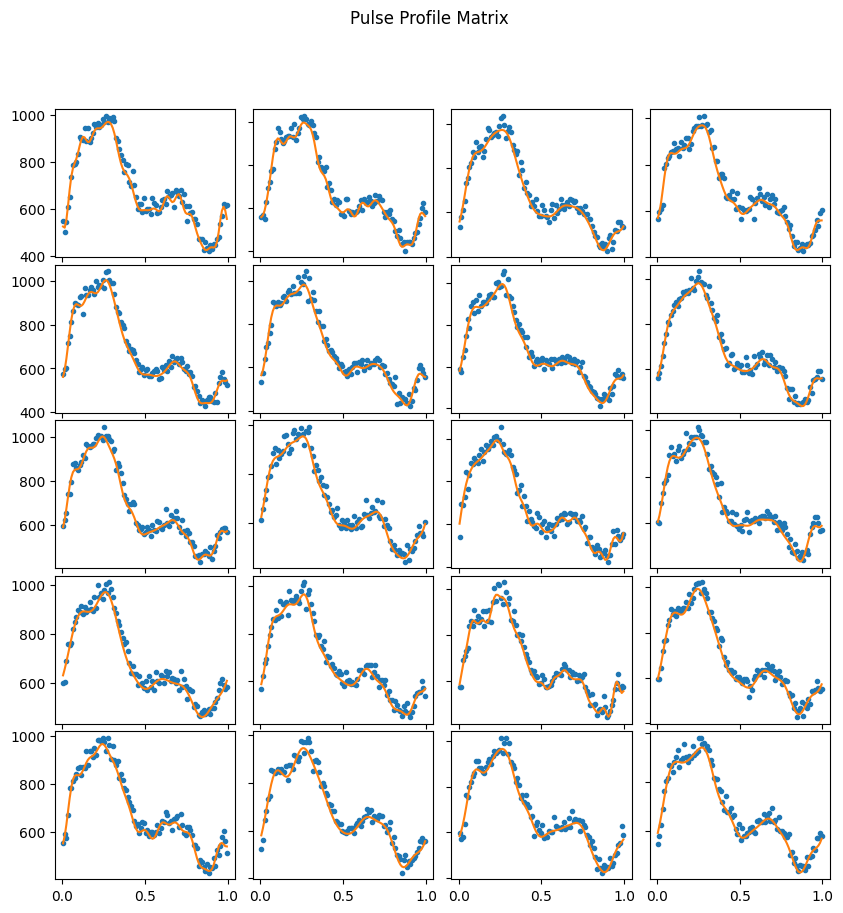

In [160]:
reload(IF)
guess_freq = correct_L[0][np.argmax(correct_L[1])]
orders, model_phases, counts, phasefolded_time = IF.pulse_profile_matrix(Time_segments, Time_phase_data['TIME'][0], [guess_freq])




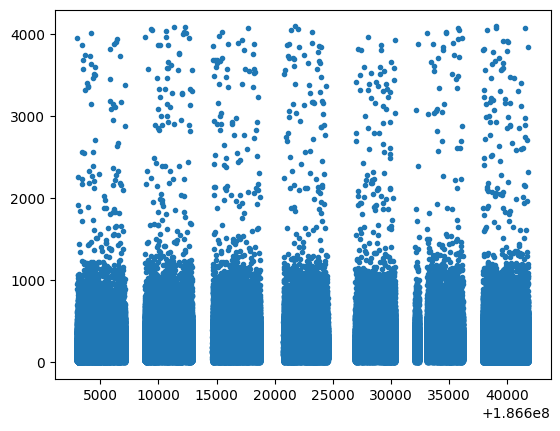

In [8]:
plt.plot(Time_phase_data['TIME'], Time_phase_data['PI'], '.')

# Getting the ENERGY pulse profile matrix

In [154]:
#Getting sizes of bins

#nmin and nmax are the minimum and maximum values of the energies we are considering
#time_data and energy_data are the arrays containing the energy and time data
#nbin is the number of segments we want to make -> if nbin negative use logarithmic
                                                #-> if nbin positive use linear
def segment_energywise(time_data, energy_data, nmin, nmax, nbin):
    if nbin<0:
        bins = 10**(np.linspace(np.log10(nmin), np.log10(nmax), np.abs(nbin)+1))
        print(bins)
    else:
        bins = np.linspace(nmin, nmax, nbin+1)

    energy_time_segments = []
    energy_time_segment = []
    energy_segments = []
    energy_segment = []
    if nbin<0:
        for i in range(np.abs(nbin)):
            for j in range(len(energy_data)):
                if bins[i] < Time_phase_data['PI'][j] < bins[i+1]:
                    energy_segment.append(Time_phase_data['PI'][j]*4e-2)
                    energy_time_segment.append(correct_orbit_time[j])
            energy_segments.append(energy_segment)
            energy_time_segments.append(energy_time_segment)
            energy_time_segment=[]
            energy_segment=[]
    else: 
        for i in range(nbin):
            for j in range(len(energy_data)):
                if bins[i] < Time_phase_data['PI'][j] < bins[i+1]:
                    energy_segment.append(Time_phase_data['PI'][j]*4e-2)
                    energy_time_segment.append(correct_orbit_time[j])
            energy_segments.append(energy_segment)
            energy_time_segments.append(energy_time_segment)
            energy_time_segment=[]
            energy_segment=[]
    return energy_time_segments, energy_segments

energy_time_segments, energy_segments = segment_energywise(correct_orbit_time, Time_phase_data['PI'], 3, 1800, 50)

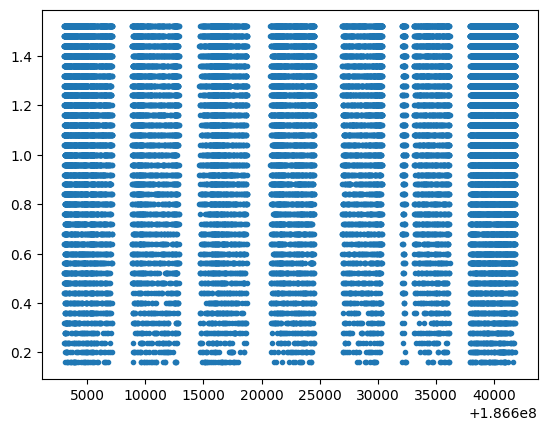

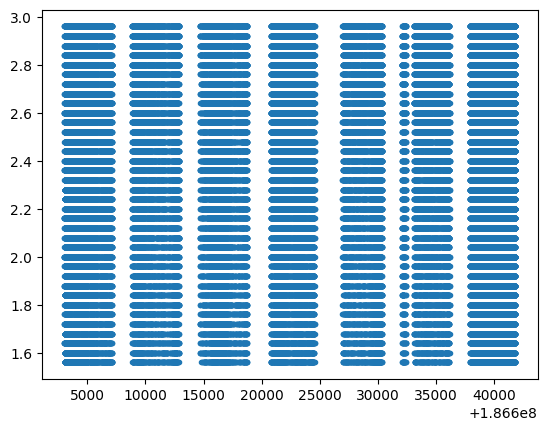

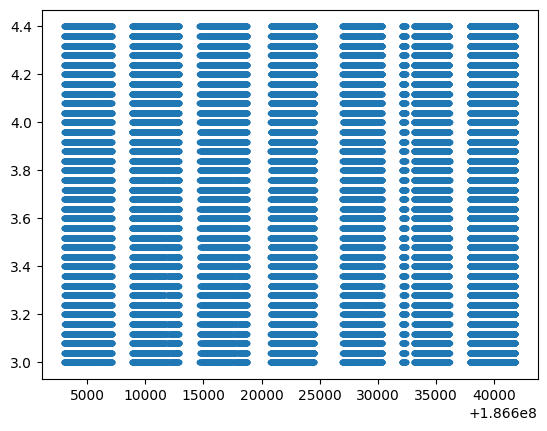

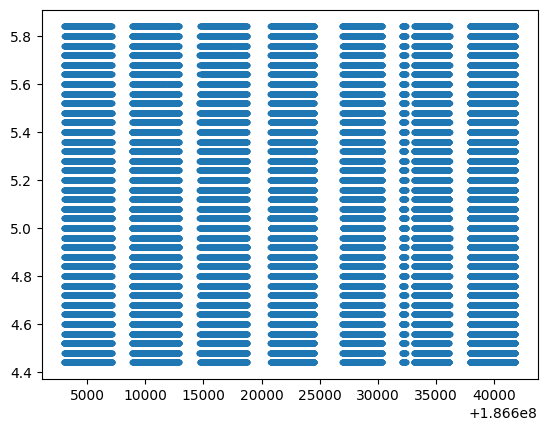

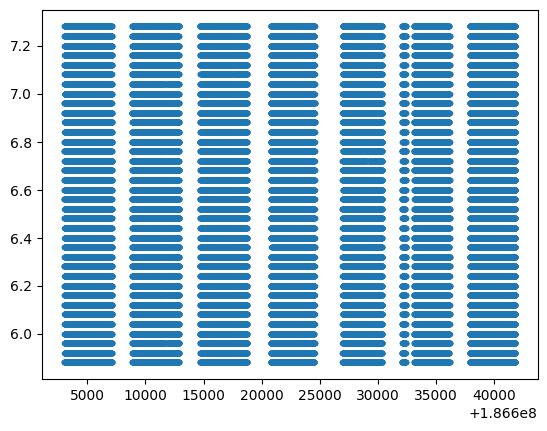

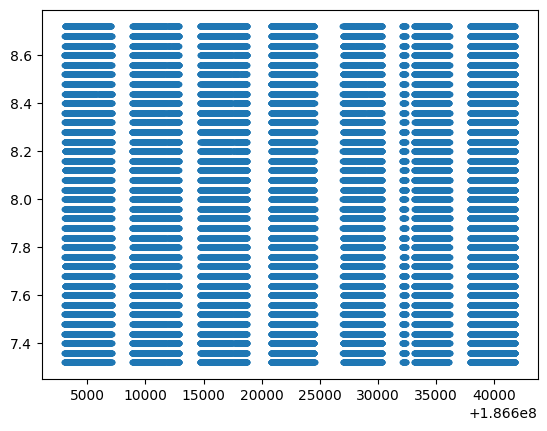

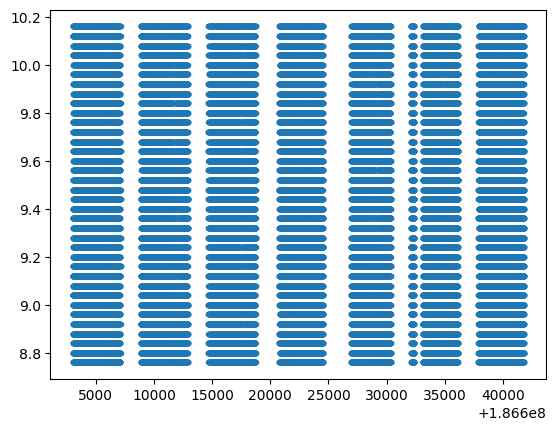

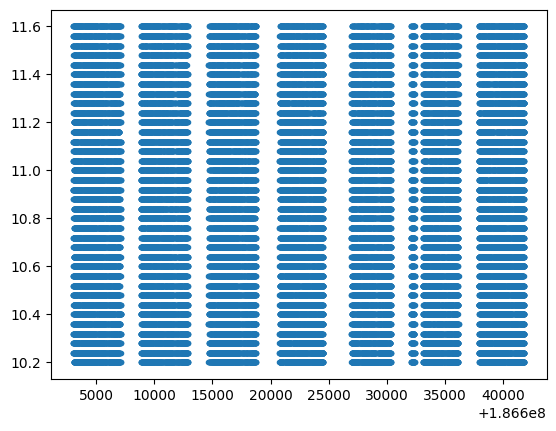

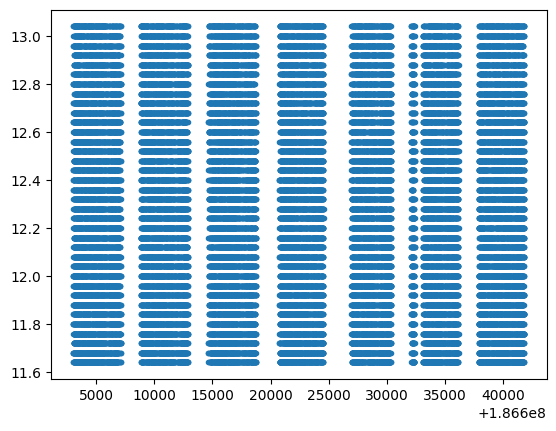

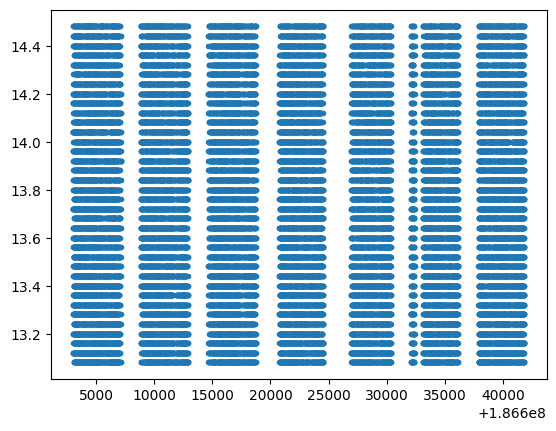

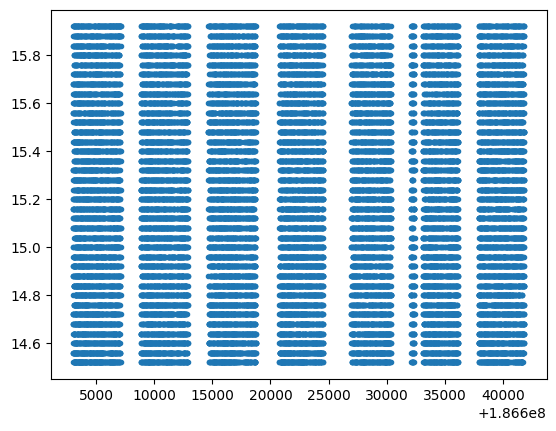

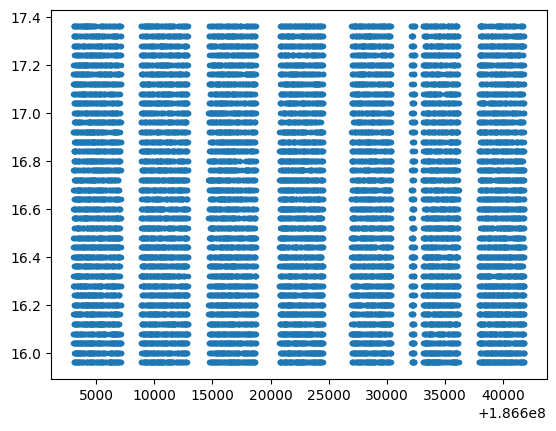

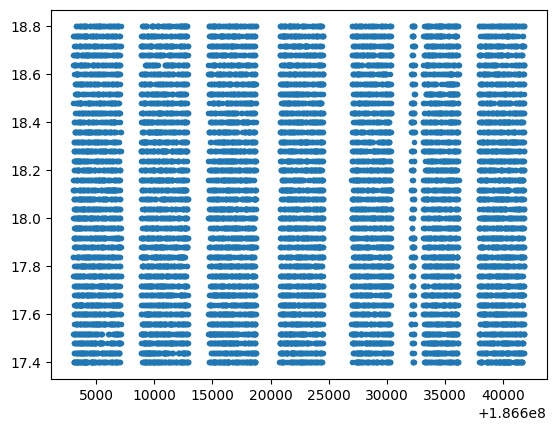

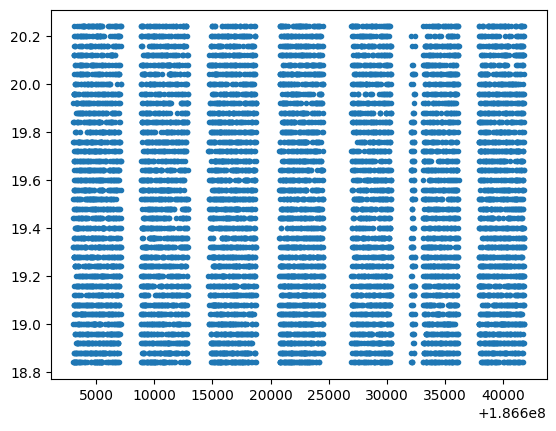

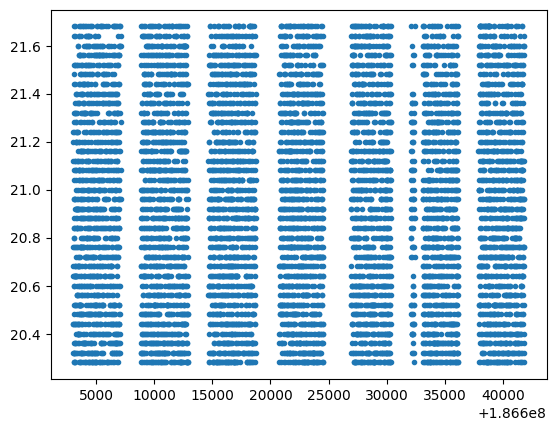

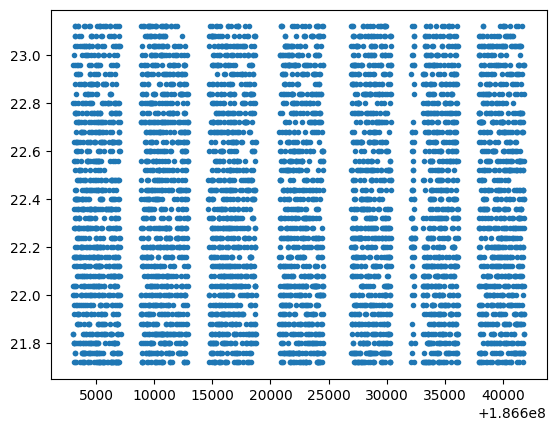

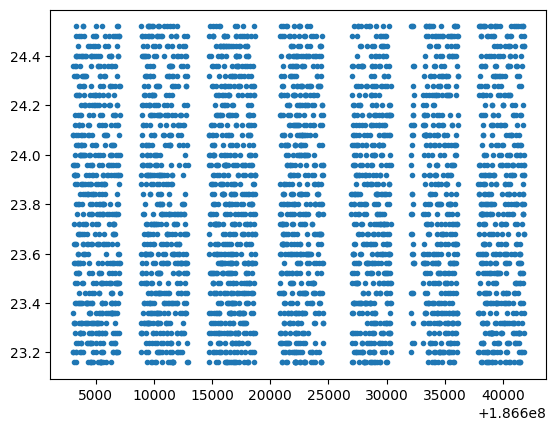

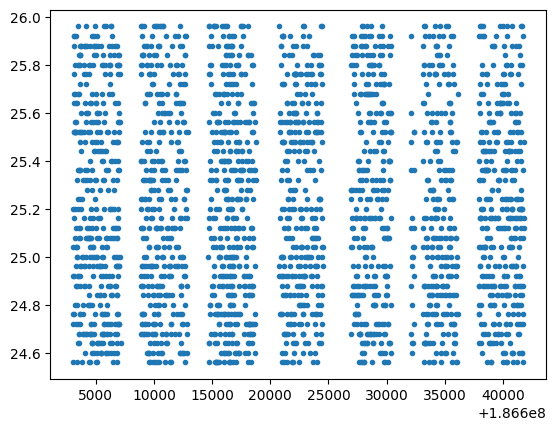

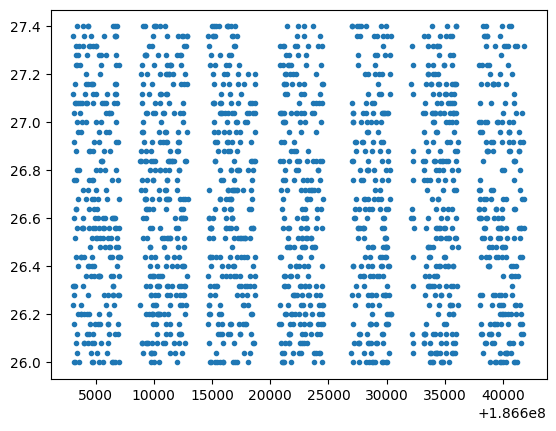

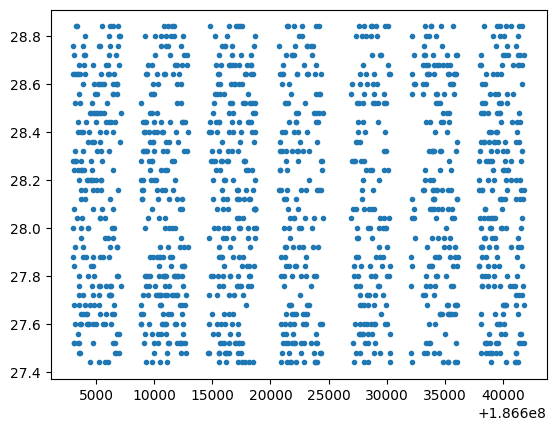

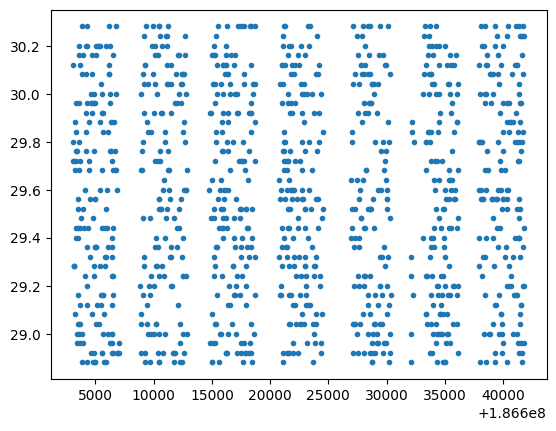

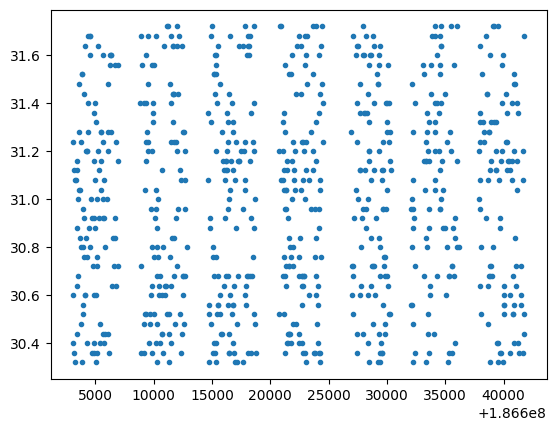

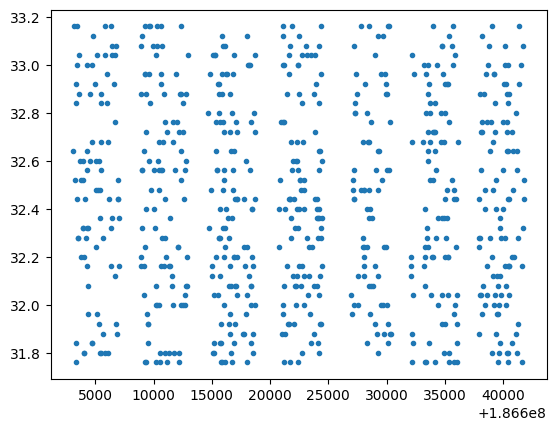

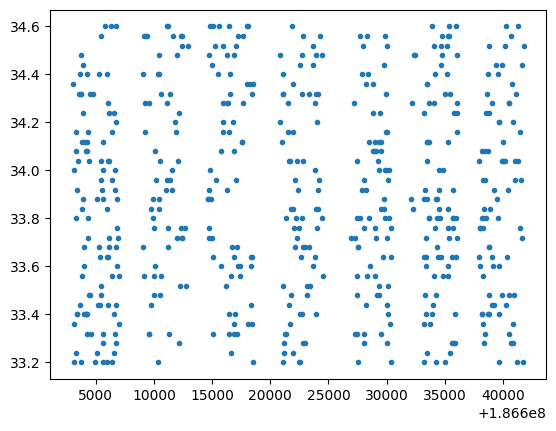

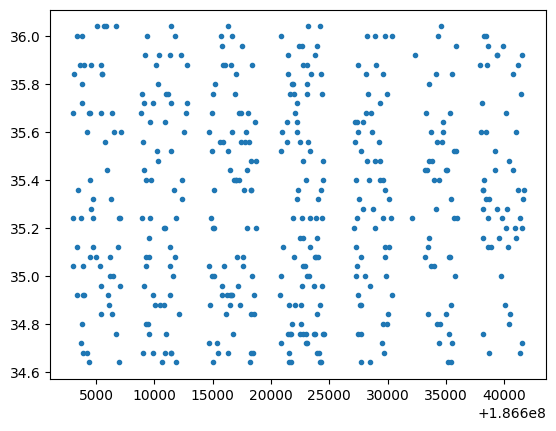

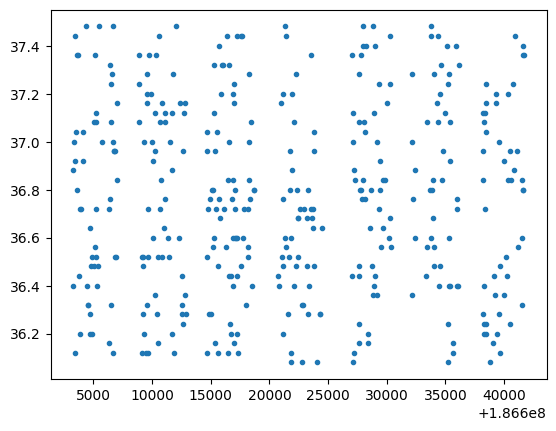

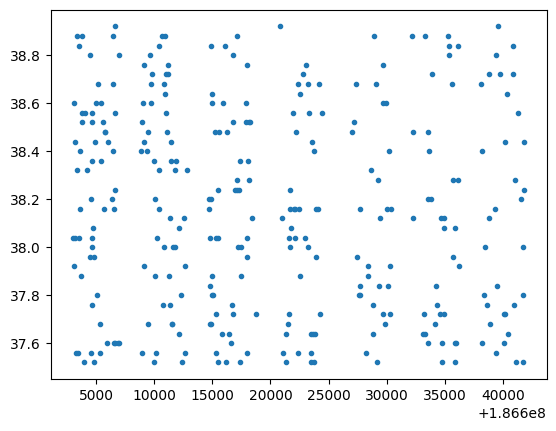

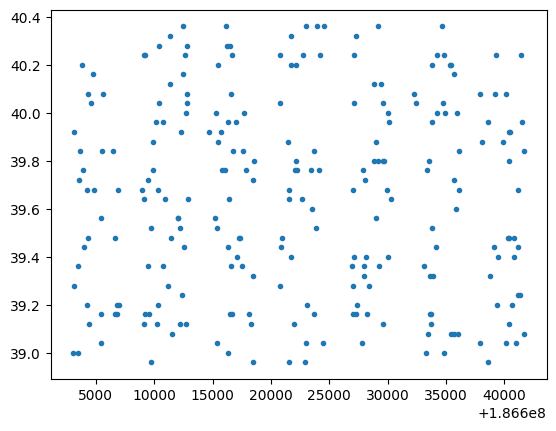

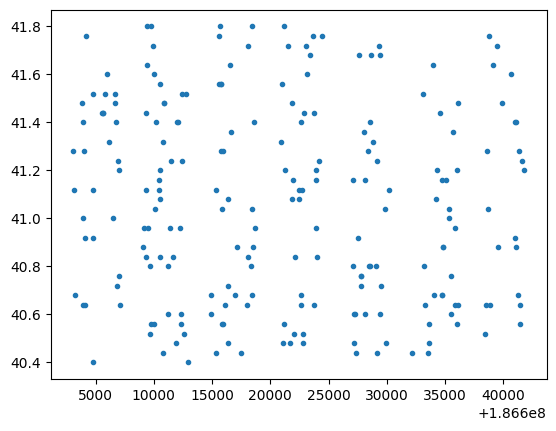

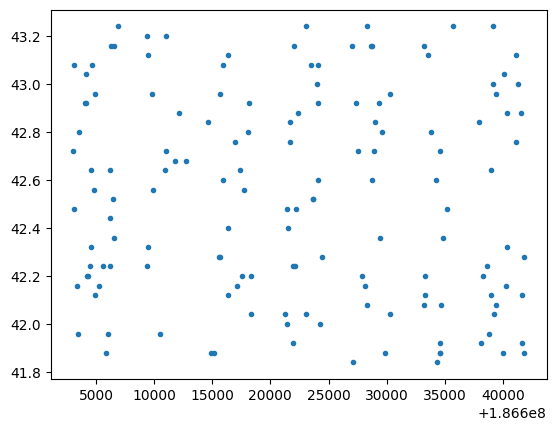

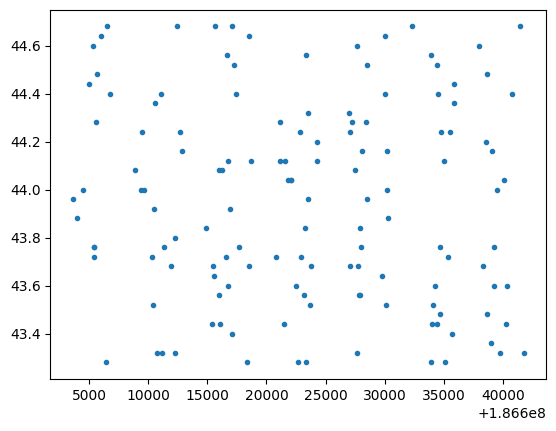

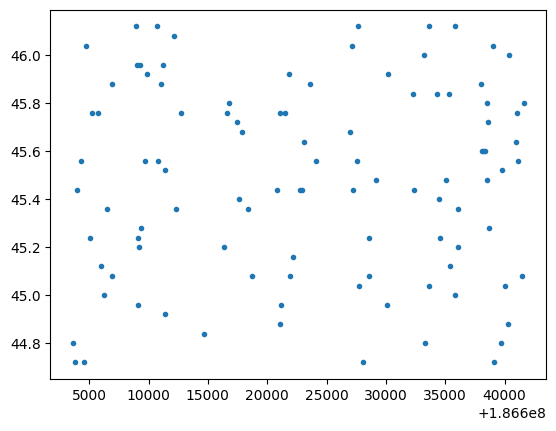

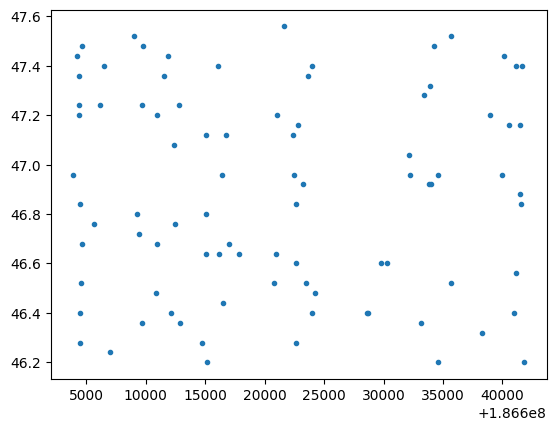

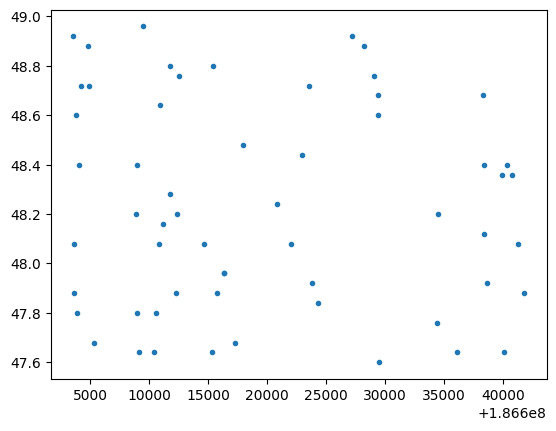

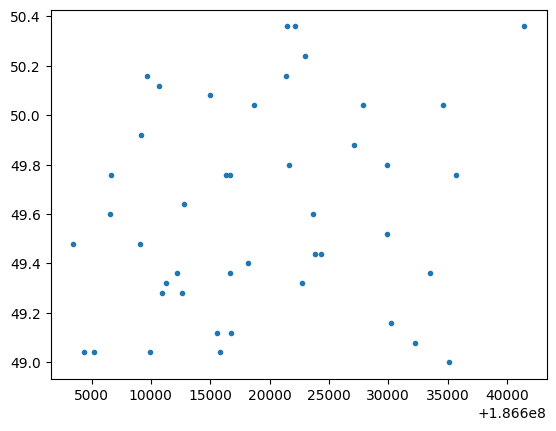

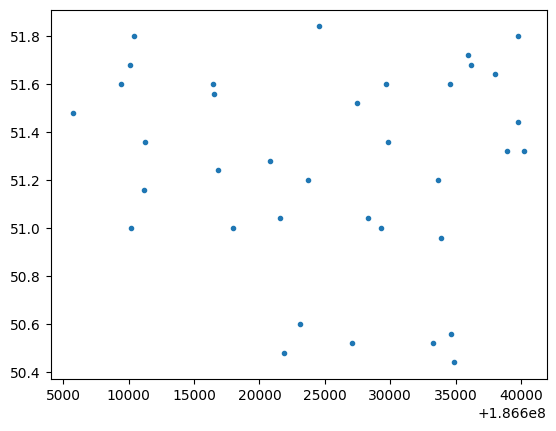

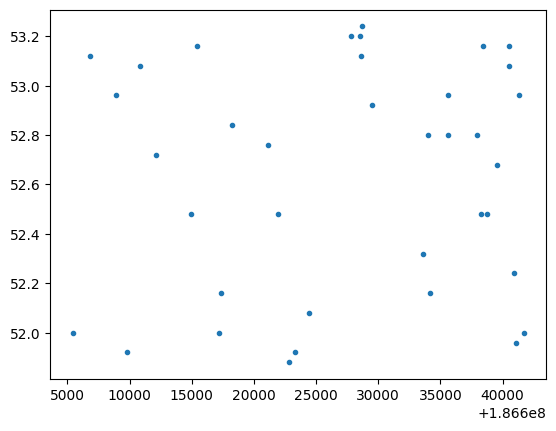

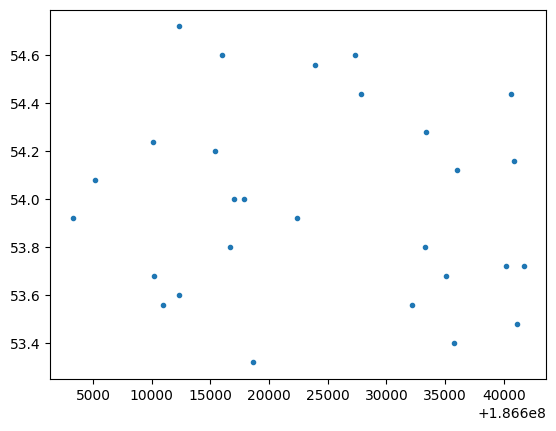

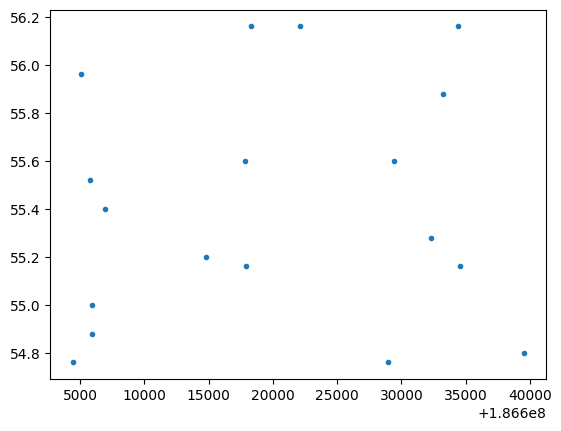

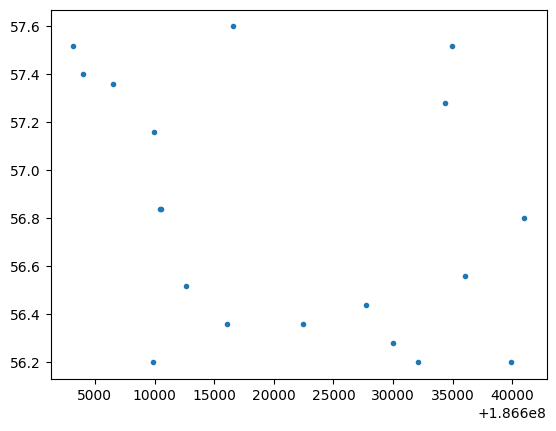

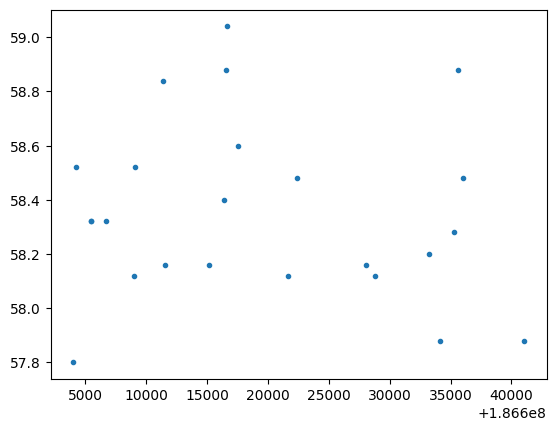

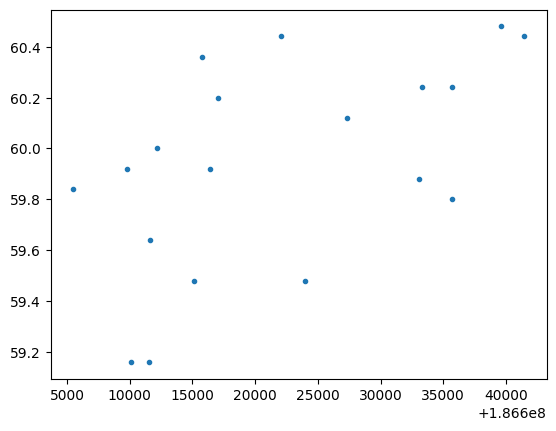

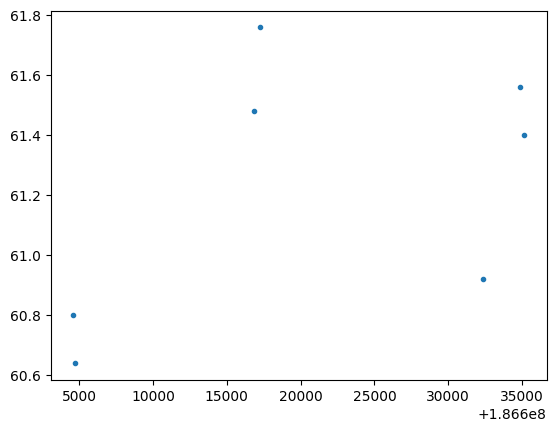

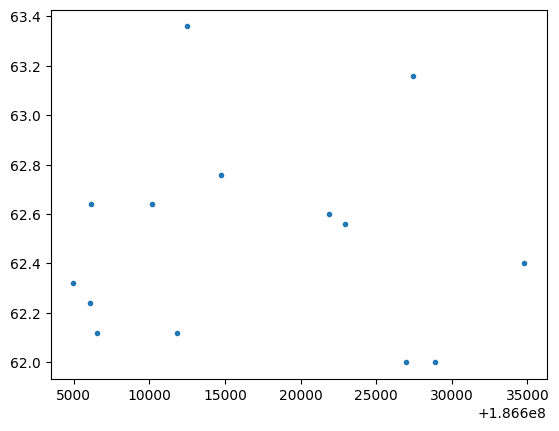

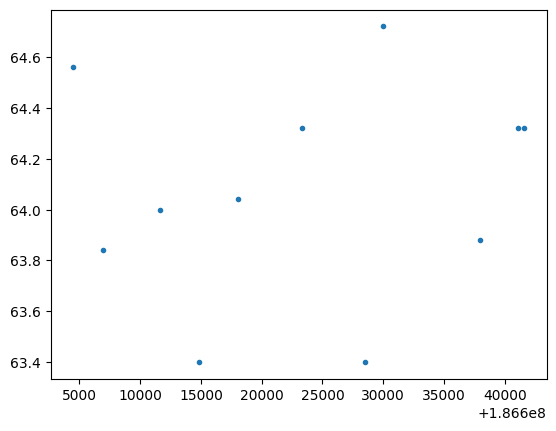

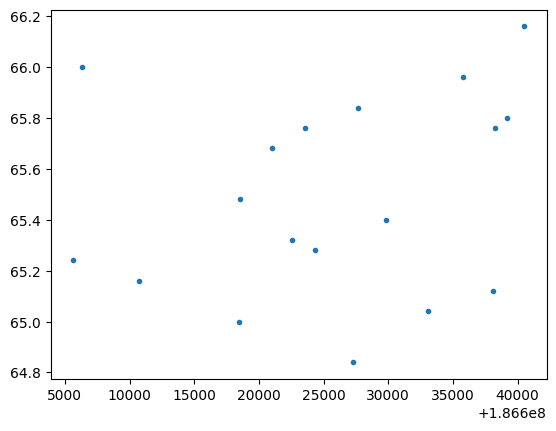

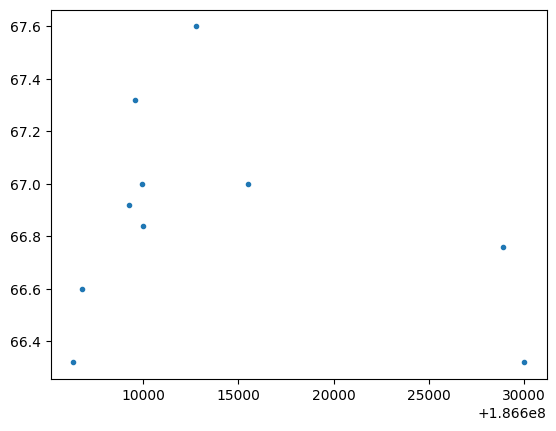

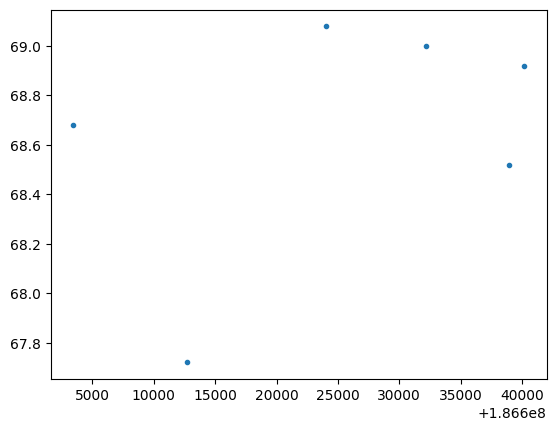

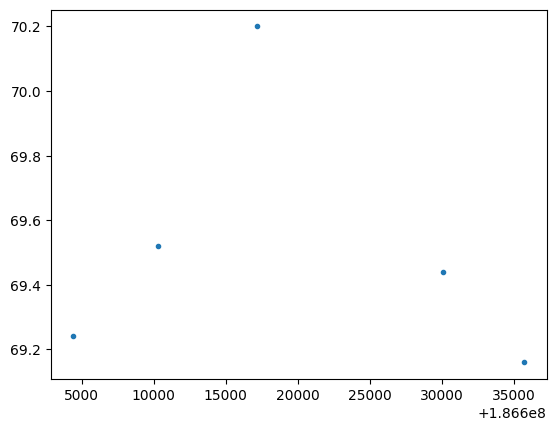

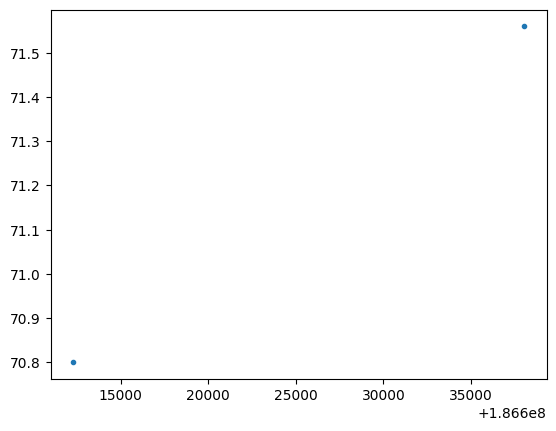

In [157]:
for i in range(50):
    plt.plot(energy_time_segments[i], energy_segments[i], '.')
    plt.show()

In [75]:
len(energy_segments[2])

625

## Plotting the energy pulse profile matrix 

18
11
13
11
10
10
11
11
11
9
15
23
12
8
3
6
30
3
3
24


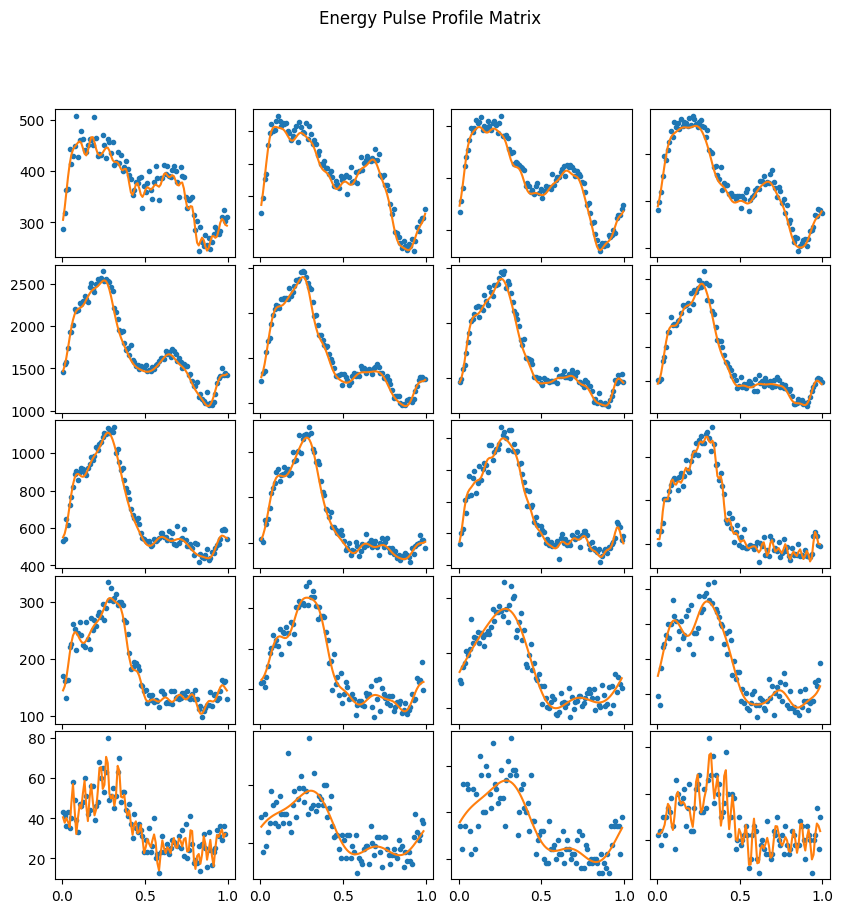

In [159]:
reload(IF)
#Getting the periodogram for the two segment

#energy_freq_seg, energy_power_seg = IF.get_power_and_freq(energy_time_segments, energy_segments, 2)

guess_freq = correct_L[0][np.argmax(correct_L[1])]

energy_orders, energy_model_phases, energy_counts, energy_phasefold_time=IF.pulse_profile_matrix(energy_time_segments, Time_phase_data['TIME'][0], [guess_freq], True, 20, 0.01, 0.3)



## Using bootstrap method to find the uncertainty on the phase 

The phase of first harmonic is -1.8822017860231934 +/- 0.003595367130141051
The phase of first harmonic is -1.9109526717761864 +/- 0.0012112723719798141
The phase of first harmonic is -1.8398226231688022 +/- 0.0006435865766700196
The phase of first harmonic is -1.7036728087515745 +/- 0.0005513990910239111
The phase of first harmonic is -1.632993774475007 +/- 0.0004217430268271506
The phase of first harmonic is -1.5560796952146525 +/- 0.0002630001073376702
The phase of first harmonic is -1.5381725050200596 +/- 0.00020927626825352537
The phase of first harmonic is -1.4918933282890576 +/- 0.00014106909336437923
The phase of first harmonic is -1.4917800176193778 +/- 0.0001247068226959954
The phase of first harmonic is -1.5039705349907568 +/- 0.00016685676933006076
The phase of first harmonic is -1.5044672281175127 +/- 0.00018763422664372397
The phase of first harmonic is -1.502425135861378 +/- 0.00020922702373963621
The phase of first harmonic is -1.5347005170833898 +/- 0.00023578889215827

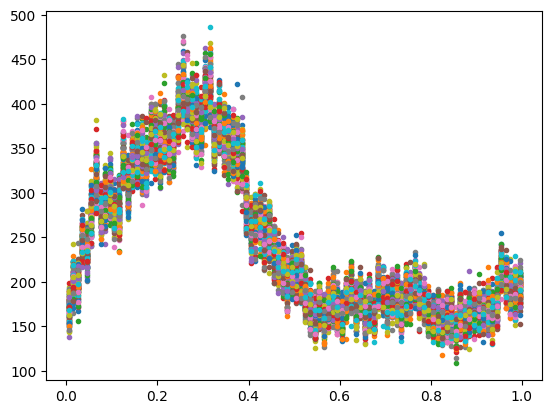

In [94]:
#Get the phase uncertainty for first harmonic for a given pulse profile using 
#k realizations of said pulse profile.
#k: number of realizations
#pulse_profile: bin times and counts per bin
def bootstrap(pulse_profile, k):
    #Getting the time and counts data
    time, counts = pulse_profile
    
    #Setting up lists for the fake pulse profile values
    #and matrix multiplication step as well as the k realizations 
    #of the first harmonic phase
    fake_profiles = []
    fake_profile = []
    row=[]
    phases_k=[]
        
    #Getting the actual phase of first harmonic for the pulse profile we are considering
    #to make sure our results are sensible 
    true_phase = np.arctan2(np.fft.rfft(counts).imag, np.fft.rfft(counts).real)[1]
        
    #Making k realizations of our pulse profile using a Poisson distibution centered
    #on the number of photon counts of each point in the pulse profile.
    for i in range(len(counts)):
        fake_profile.append(st.poisson.rvs(mu=counts[i], size=k))
        
    #Re-making the k realizations so that instead of having an n x k matrix 
    #We have a k x n matrix -> will make it easier to plot the k realizations of the 
    #pulse profile.
    for j in range(k):
        for i in range(len(fake_profile)):
            row.append(fake_profile[i][j])
        fake_profiles.append(row)
        row=[]
    
    #Calculating the phase of first harmonic for the k realizations 
    #and populating the phases_k list. 
    for l in range(len(fake_profiles)):
        fft = np.fft.rfft(fake_profiles[l])
        phase_l = np.arctan2(fft.imag, fft.real)
        phases_k.append(phase_l[1])
        
    #Getting the standard deviation of our phase measurement using the 
    #bootstrapping method)
    std = (1/k)*np.sum((np.array(phases_k)-np.mean(phases_k))**2)
    
     
    return fake_profiles, std, true_phase

test = bootstrap((energy_phasefold_time[15], energy_counts[15]), 100)
#print('The true phase is ', test[2], ' The guessed phase is ', test[0], 'and the uncertainty on true phase is ',test[1])
for i in range(len(test[0])):
    plt.plot(energy_phasefold_time[15], test[0][i], '.')
    
for i in range(len(energy_phasefold_time)):
    temp2 = bootstrap((energy_phasefold_time[i], energy_counts[i]), 100)
    print('The phase of first harmonic is', temp2[2], '+/-', temp2[1])

## Defining a function to calculate the RMS

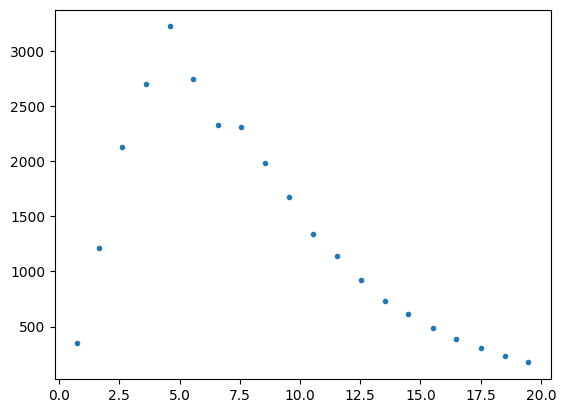

In [84]:
def RMS_calculator(counts):
    counts_fft = np.fft.rfft(counts)
    amps = np.sqrt(counts_fft.imag**2 + counts_fft.real**2)
    RMS = np.sqrt(np.sum(amps**2))/len(amps)
    return RMS

## Re-making the bootstrapping method to be more general and calculating the phase and RMS for each energy pulse profile (i.e. making sure the new functions work)

In [149]:
def bootstrap_generate(counts, k):
    #Setting up lists for the fake pulse profile values
    #and matrix multiplication step
    fake_profiles = []
    fake_profile = []
    row=[]
    
    #Making k realizations of our pulse profile using a Poisson distibution centered
    #on the number of photon counts of each point in the pulse profile.
    for i in range(len(counts)):
        fake_profile.append(st.poisson.rvs(mu=counts[i], size=k))
        
    #Re-making the k realizations so that instead of having an n x k matrix 
    #We have a k x n matrix -> will make it easier to plot the k realizations of the 
    #pulse profile.
    for j in range(k):
        for i in range(len(fake_profile)):
            row.append(fake_profile[i][j])
        fake_profiles.append(row)
        row=[]
    return fake_profiles

def bootstrap_total(counts, k, func, *args):
    profiles = bootstrap_generate(counts, k)
    values = []
    for i in range(len(profiles)):
        values.append(func(profiles[i], *args))
    std = (1/k)*np.sum((np.array(values)-np.mean(values))**2)
    return std

def get_first_harmonic_phase(counts):
    fft = np.fft.rfft(counts)
    phase_l = np.arctan2(fft.imag, fft.real)[1]
    return phase_l
    
RMS_error = np.ones(len(energy_counts))
for i in range(len(energy_counts)):
    RMS_error[i] = bootstrap_total(energy_counts[i], 100, RMS_calculator)
    print('RMS is:',RMS_calculator(energy_counts[i]), ' +/- ', bootstrap_total(energy_counts[i], 1000, RMS_calculator))
    print('First phase is:', get_first_harmonic_phase(energy_counts[i]), ' +/- ', bootstrap_total(energy_counts[i], 100, get_first_harmonic_phase)) 
    print('\n')
         

RMS is: 4968.508871404856  +/-  97.54776004626231
First phase is: -1.5538248257915377  +/-  0.00013378951576453453


RMS is: 5368.072539820229  +/-  120.32350824166666
First phase is: -1.501977289456194  +/-  4.607054146971264e-05


RMS is: 4498.49219914228  +/-  88.84084334404446
First phase is: -1.5038331291491556  +/-  3.445985026845427e-05


RMS is: 2839.9139829585715  +/-  57.647603569869595
First phase is: -1.531312826443992  +/-  6.95287969477839e-05


RMS is: 1075.5102445090095  +/-  22.787571791471642
First phase is: -1.528187981445387  +/-  0.00014658863406023058


RMS is: 225.90567323553427  +/-  4.443335554724932
First phase is: -1.5948705439393582  +/-  0.0008628436564538306


RMS is: 64.76595093102547  +/-  1.51550066347146
First phase is: -1.8510412585999494  +/-  0.0009730084139438174




## Plotting the RMS against energy 

Text(0.5, 1.0, 'Plot of the RMS against Energy')

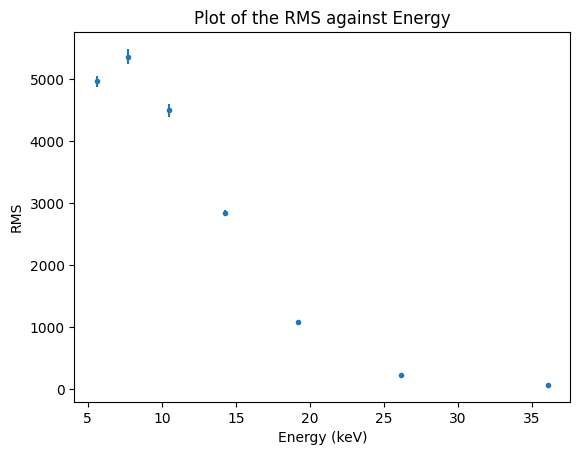

In [152]:
RMSs = np.zeros(len(energy_counts))
avg = np.zeros(len(energy_counts))
for i in range(len(energy_counts)):
    RMSs[i] = RMS_calculator(energy_counts[i])
    avg[i] = np.mean(energy_segments[i])

fig, ax = plt.subplots(1, 1)
ax.errorbar(avg, RMSs, yerr=RMS_error, fmt='.')
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('RMS')
ax.set_title('Plot of the RMS against Energy')